In [1]:
%matplotlib inline

import logging
import os
import sys
import time
from datetime import datetime
from pathlib import Path
from typing import List, Optional
import SimpleITK as sitk

import glob
import ants
import matplotlib.pyplot as plt
import numpy as np
from ants import iMath, resample_image_to_target
import argparse

from aind_ccf_reg.preprocess import perc_normalization
from aind_ccf_reg.configs import PathLike
from aind_ccf_reg.plots import plot_reg, plot_antsimgs, plot_reg_before_after


## apply inverse transform, deform RT to the exaSPIM template space 

In [2]:


""" constant variables for class and color definition"""
CLASS_COLOR_MAP = {
    # 0: [256, 256, 256],
    # 64: [255, 0, 0],
    # 170: [0, 255, 0],
    # 35: [0, 0, 255],
    # 262: [255, 0, 255],
    # 100: [0, 255, 255],
    # 908: [255, 55, 0],
    # 91: [0, 128, 128],
    0.0: [256, 256, 256],
    1.0: [255, 0, 255],
    2.0: [0, 255, 0],
    3.0: [0, 0, 255],
    
}
 
def overlay_labels(ants_mask, template, figpath, title, vmin=0, vmax=500, loc=2):
    """" overlay labels and templates """
    ants_mask = ants_mask.numpy()
    half_size = (np.array(ants_mask.shape) / loc).astype(int)
    fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        
    mask2d_map = [ 
          ants_mask[half_size[0], :, :], 
          ants_mask[:, half_size[1], :], 
          ants_mask[:,:, half_size[2],]]

    img2d_map = [ 
          template[half_size[0], :, :], 
          template[:, half_size[1], :], 
          template[:,:, half_size[2],]]

    for loc in [0, 1, 2]:   
        label_map = mask2d_map[loc]
        image_map = img2d_map[loc]
        
        label_map_3d = np.ndarray(shape=(label_map.shape[0], label_map.shape[1], 3), dtype=int)

        for i in range(0, label_map.shape[0]):
            for j in range(0, label_map.shape[1]):
                label_map_3d[i][j] = CLASS_COLOR_MAP[ label_map[i][j] ]  
                
        ax[loc].imshow( image_map, cmap='gray', vmin=vmin, vmax=vmax )
        ax[loc].imshow( (label_map_3d/label_map_3d.max() * 255).astype(np.uint8) , alpha=0.5)
   
    fig.suptitle(title, y=0.9)
    if figpath:
        plt.savefig(f"{figpath}.jpg", bbox_inches = 'tight', pad_inches = 0.1)

# Deform labels_exaspim to CCF with exaspim-to-ccf registration

In [3]:
out_prefix = "/results/"

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]



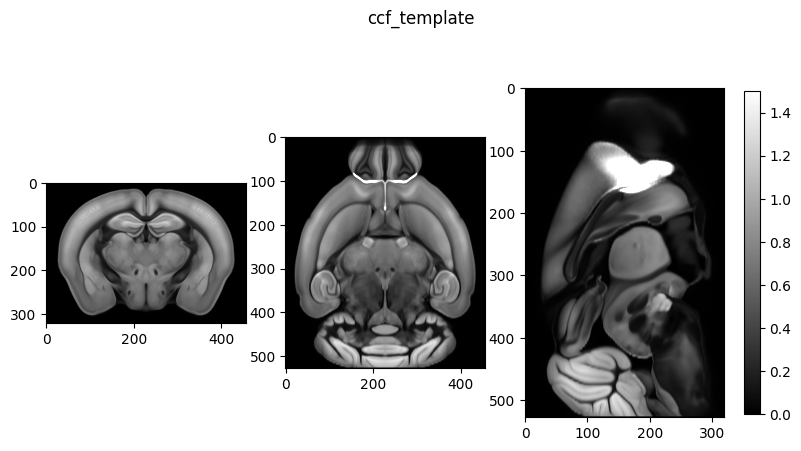

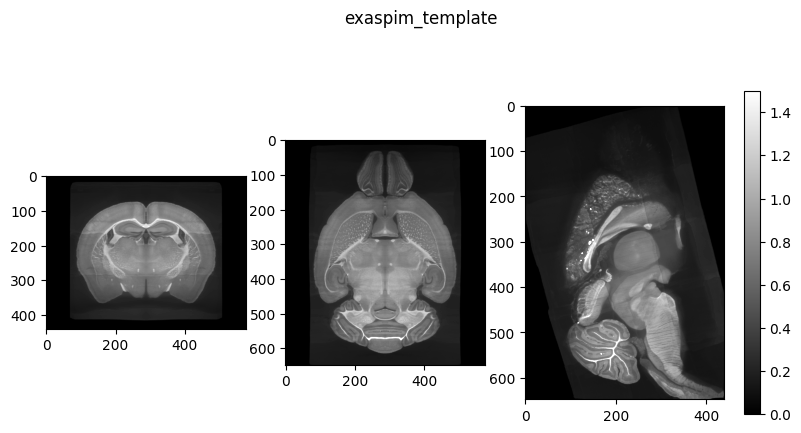

In [4]:
exaspim = ants.image_read("/data/exaspim_template_7sujects_nomask_25um_round6.nii.gz") # 25um
ccf = ants.image_read('../data/allen_mouse_ccf/average_template/average_template_25.nii.gz')
ccf = perc_normalization(ccf)

print(ccf)
plot_antsimgs(ccf, 
              f"{out_prefix}/ccf_template",
              title=f"ccf_template", 
              vmin=0, vmax=1.5)

print(exaspim)
plot_antsimgs(exaspim, 
              f"{out_prefix}/exaspim_template",
              title=f"exaspim_template", 
              vmin=0, vmax=1.5)


In [6]:
ccf_to_exaspim_transform_path = [
    "/data/reg_exaspim_template_to_ccf_withGradMap_10um_v1.0/0GenericAffine.mat",
    "/data/reg_exaspim_template_to_ccf_withGradMap_10um_v1.0/1InverseWarp.nii.gz",
]

exaspim_to_ccf_transform_path = [
    "/data/reg_exaspim_template_to_ccf_withGradMap_25um_v1.0/1Warp.nii.gz",
    "/data/reg_exaspim_template_to_ccf_withGradMap_25um_v1.0/0GenericAffine.mat",
]

# exaspim_to_ccf_transform_path_withRT = [
#     "/data/exaspim_7subj_to_ccf_img_withGrad_withRT_synsample2_iter500_200_100_10_wG0.5/1Warp.nii.gz",
#     "/data/exaspim_7subj_to_ccf_img_withGrad_withRT_synsample2_iter500_200_100_10_wG0.5/0GenericAffine.mat",
# ]
# exaspim_to_ccf_transform_path_withRT = [
#     "/data/exaspim_7subj_to_ccf_img_withGrad_withRT_synsample2_iter500_200_100_10_wG0.5/1Warp.nii.gz",
#     "/data/exaspim_7subj_to_ccf_img_withGrad_withRT_synsample2_iter500_200_100_10_wG0.5/0GenericAffine.mat",
# ]

# exaspim_to_ccf_transform_path_withRT = [
#     "/data/reg_exaspim_template_to_ccf_25um_v1.1/1Warp.nii.gz",
#     "/data/reg_exaspim_template_to_ccf_25um_v1.1/0GenericAffine.mat",
# ]

# exaspim_to_ccf_transform_path_withlabels = [
#     "/data/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_synsample2_iter500_200_100_10_wG0.5/1Warp.nii.gz",
#     "/data/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_synsample2_iter500_200_100_10_wG0.5/0GenericAffine.mat",
# ]

# exaspim_to_ccf_transform_path_withlabels = [
#     "/data/reg_exaspim_template_to_ccf_25um_v1.3/1Warp.nii.gz",
#     "/data/reg_exaspim_template_to_ccf_25um_v1.3/0GenericAffine.mat",
# ]
# exaspim_to_ccf_transform_path_withlabels = [
#     "/results/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_ICP_synsample2_iter500_200_100_10_wG0.5/1Warp.nii.gz",
#     "/results/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_ICP_synsample2_iter500_200_100_10_wG0.5/0GenericAffine.mat",
# ]

# exaspim_to_ccf_transform_path_withlabels = [
#     "/results/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_ICP_py_synsample2_iter500_200_100_10_wG0.5/1Warp.nii.gz",
#     "/results/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_ICP_py_synsample2_iter500_200_100_10_wG0.5/0GenericAffine.mat",
# ]

exaspim_to_ccf_transform_path_withlabels = [
    "/data/reg_exaspim_template_to_ccf_25um_v1.4/1Warp.nii.gz",
    "/data/reg_exaspim_template_to_ccf_25um_v1.4/0GenericAffine.mat",
]
# results/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_ICP_synsample2_iter500_200_100_10_wG0.5/moved_exaspim_to_ccf_25um.nii.gz
print(exaspim_to_ccf_transform_path)
print(exaspim_to_ccf_transform_path_withlabels)



['/data/reg_exaspim_template_to_ccf_withGradMap_25um_v1.0/1Warp.nii.gz', '/data/reg_exaspim_template_to_ccf_withGradMap_25um_v1.0/0GenericAffine.mat']
['/data/reg_exaspim_template_to_ccf_25um_v1.4/1Warp.nii.gz', '/data/reg_exaspim_template_to_ccf_25um_v1.4/0GenericAffine.mat']


In [7]:
from sklearn.metrics import f1_score, jaccard_score, accuracy_score, precision_score, recall_score
from datetime import datetime

def compute_metrics(gt, pred, valid_labels, title):
    f1_value = f1_score(gt, pred, labels=valid_labels, average=None, zero_division=np.nan)
    jac_value = jaccard_score(gt, pred, labels=valid_labels, average=None, zero_division=0)
    
    accuracy = accuracy_score(gt, pred)
    recall = recall_score(gt, pred, labels=valid_labels)
    precision = precision_score(gt, pred, labels=valid_labels)
    
    print(f"{title}: f1={f1_value[0]:.2f}, Jaccard={jac_value[0]:.2f}, accuracy={accuracy:.2f}, recall={recall:.2f}, precision={precision:.2f}")
    
    # Overlap score = Volume of (region1 ∩ region2) / Volume of region1
    # Make sure both are boolean arrays
    region1 = pred.astype(bool)
    region2 = gt.astype(bool)

    # Calculate intersection
    intersection = np.logical_and(region1, region2)

    # Compute volumes
    region1_volume = np.sum(region1)
    intersection_volume = np.sum(intersection)

    if region1_volume == 0:
        return 0.0  # Avoid divide-by-zero
    
    score = intersection_volume / region1_volume

    print(f"{title}: overlap={score:.2f}")





label_ccf_file: /data/RT_anno_for_reg/ccf_anno_RT_25um.nii.gz
label_exaspim_file: /data/RT_anno_for_reg/exaspim_anno_RT_25um_twosides.nii.gz
ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]

ccf labels unique values: [0. 1.]
exaspim template labels unique values: [0. 1. 2.]
ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]

exaspim template labels unique values: [0. 1.]
label_ccf_file: /data/RT_anno_for_reg/ccf_anno_RT_25um.nii.gz
label_exaspim

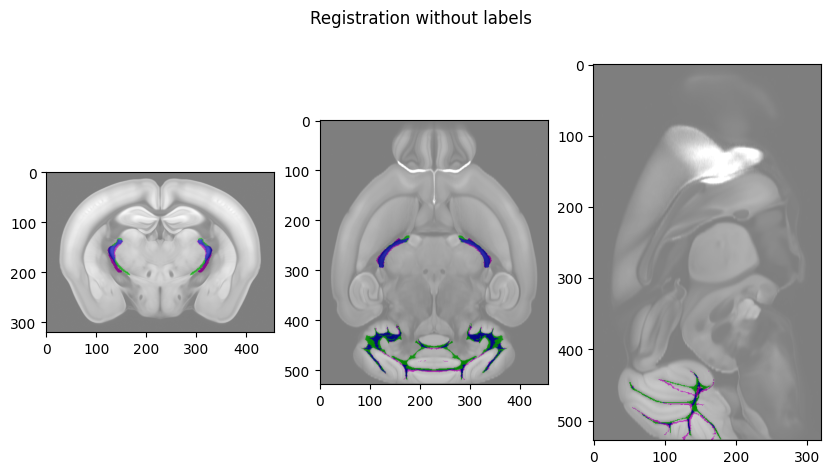

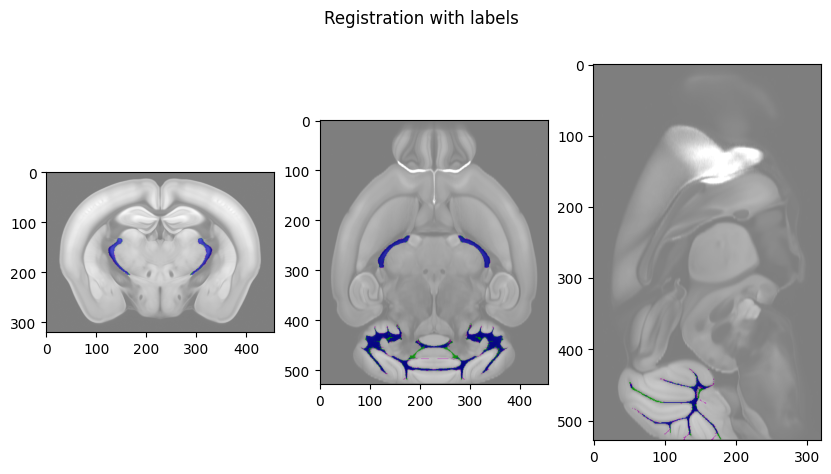

In [11]:
labels_ccf_path = [
    "/data/RT_anno_for_reg/ccf_anno_RT_25um.nii.gz",
    "/data/RT_anno_for_reg/ccf_anno_Arbor_Vitae_25um.nii.gz",
    "/data/RT_anno_for_reg/ccf_anno_inferior_cerebellar_peduncle_25um.nii.gz",
    "/data/RT_anno_for_reg/ccf_anno_pyramid_25um.nii.gz"
]

labels_exaspim_path = [
    "/data/RT_anno_for_reg/exaspim_anno_RT_25um_twosides.nii.gz",
    "/data/RT_anno_for_reg/exaspim_anno_Arbor_Vitae_25um.nii.gz",
    "/data/RT_anno_for_reg/exaspim_anno_inferior_cerebellar_peduncle_25um_twosides.nii.gz",
    "/data/RT_anno_for_reg/exaspim_anno_pyramid_25um.nii.gz"
]

labels_ccf =  ants.image_read("/data/RT_anno_for_reg/ccf_anno_RT_25um.nii.gz") \
            + ants.image_read("/data/RT_anno_for_reg/ccf_anno_Arbor_Vitae_25um.nii.gz") \
            + ants.image_read("/data/RT_anno_for_reg/ccf_anno_inferior_cerebellar_peduncle_25um.nii.gz") \
            + ants.image_read("/data/RT_anno_for_reg/ccf_anno_pyramid_25um.nii.gz")


labels_exaspim = ants.image_read("/data/RT_anno_for_reg/exaspim_anno_RT_25um_twosides.nii.gz") \
                + ants.image_read("/data/RT_anno_for_reg/exaspim_anno_Arbor_Vitae_25um.nii.gz") \
                + ants.image_read("/data/RT_anno_for_reg/exaspim_anno_inferior_cerebellar_peduncle_25um_twosides.nii.gz") \
                 + ants.image_read("/data/RT_anno_for_reg/exaspim_anno_pyramid_25um.nii.gz")


for label_ccf_file, label_exaspim_file in zip(labels_ccf_path[:1], labels_exaspim_path):
    print("")
    print("")
    print(f"label_ccf_file: {label_ccf_file}")
    print(f"label_exaspim_file: {label_exaspim_file}")
#     labels_ccf = ants.image_read(label_ccf_file)
#     labels_exaspim =  ants.image_read(label_exaspim_file) 
    
    labels_ccf =  ants.image_read("/data/RT_anno_for_reg/ccf_anno_RT_25um.nii.gz") \
            + ants.image_read("/data/RT_anno_for_reg/ccf_anno_Arbor_Vitae_25um.nii.gz") \
            + ants.image_read("/data/RT_anno_for_reg/ccf_anno_inferior_cerebellar_peduncle_25um.nii.gz") \
            + ants.image_read("/data/RT_anno_for_reg/ccf_anno_pyramid_25um.nii.gz")


    labels_exaspim = ants.image_read("/data/RT_anno_for_reg/exaspim_anno_RT_25um_twosides.nii.gz") \
                    + ants.image_read("/data/RT_anno_for_reg/exaspim_anno_Arbor_Vitae_25um.nii.gz") \
                    + ants.image_read("/data/RT_anno_for_reg/exaspim_anno_inferior_cerebellar_peduncle_25um_twosides.nii.gz") \
                     + ants.image_read("/data/RT_anno_for_reg/exaspim_anno_pyramid_25um.nii.gz")

    print(labels_ccf)
    print(labels_exaspim)

    print("ccf labels unique values:", np.unique(labels_ccf.numpy()))
    print("exaspim template labels unique values:", np.unique(labels_exaspim.numpy()))

    labels_exaspim_arr = labels_exaspim.numpy()
    labels_exaspim_arr[labels_exaspim_arr > 0] = 1
    labels_exaspim = ants.from_numpy(
            labels_exaspim_arr.astype("float32"), 
            spacing=labels_exaspim.spacing,
            origin=labels_exaspim.origin, 
            direction=labels_exaspim.direction
           )
    print(labels_exaspim)
    print("exaspim template labels unique values:", np.unique(labels_exaspim.numpy()))

    labels_moved1 = ants.apply_transforms(
        fixed=ccf,
        moving=labels_exaspim,
        transformlist=exaspim_to_ccf_transform_path,
        interpolator="nearestNeighbor",
    )

    labels_moved2 = ants.apply_transforms(
        fixed=ccf,
        moving=labels_exaspim,
        transformlist=exaspim_to_ccf_transform_path_withlabels,
        interpolator="nearestNeighbor",   
    )

    # print("")
    # # overlay RT labels on CCF
    # overlay_labels(labels_moved1, ccf, "movedlabels_overlay_ccf_1", title="Registration without labels", vmin=0, vmax=None)
    # print("")
    # # overlay RT labels on CCF
    # overlay_labels(labels_moved2, ccf, "movedlabels_overlay_ccf_2", title="Registration with labels", vmin=0, vmax=None)

    # ---------------------------
    # overlay labels on CCF 
    overlay_labels(labels_moved1 + labels_ccf + labels_ccf, ccf, "registration_without_labels", title="Registration without labels", vmin=0, vmax=None,loc=2)
    # overlay labels on CCF
    overlay_labels(labels_moved2 + labels_ccf + labels_ccf, ccf, "registration_with_labels", title="Registration with labels", vmin=0, vmax=None, loc=2)


    valid_labels = [1.0]
    gt = labels_ccf.numpy().flatten() # gt_labels
    pred1 = labels_moved1.numpy().flatten()
    pred2 = labels_moved2.numpy().flatten()
    
    print(f"label_ccf_file: {label_ccf_file}")
    print(f"label_exaspim_file: {label_exaspim_file}")

    title = "Before registration"
    compute_metrics(gt, pred1, valid_labels, title)

    title = "After registration"
    compute_metrics(gt, pred2, valid_labels, title)


In [15]:
ccf

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]


(528, 320, 456)
[264 160 228]
[399, 293, 214]

(528, 320, 456)
[264 160 228]
[399, 293, 214]


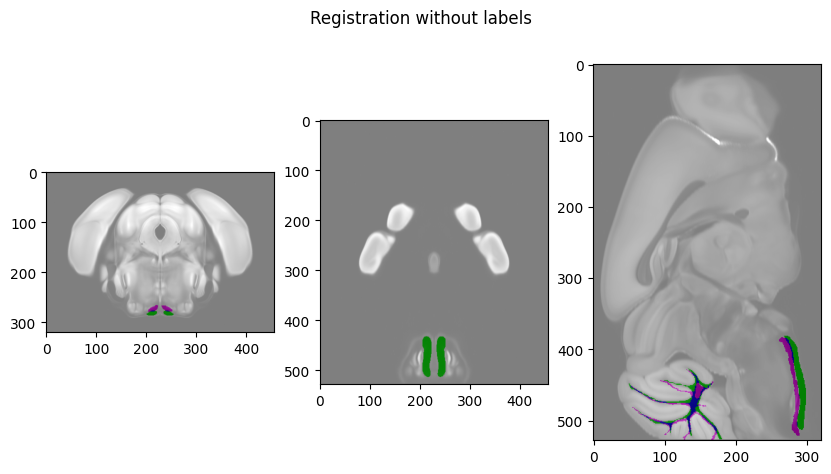

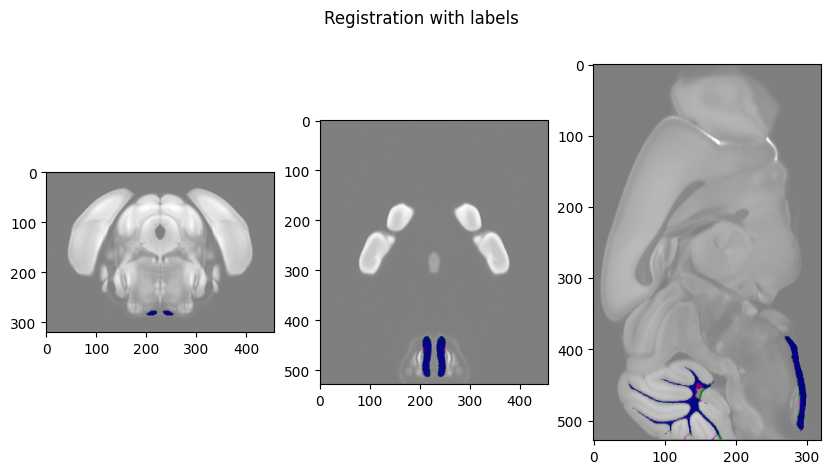

In [16]:

def overlay_labels(ants_mask, template, figpath, title, vmin=0, vmax=500, loc=2):
    """" overlay labels and templates """
    ants_mask = ants_mask.numpy()
    print(ants_mask.shape)
    half_size = (np.array(ants_mask.shape) / loc).astype(int)
    print(half_size)
    # half_size = [463, 260, 314]
    half_size = [399, 293, 214]
    print(half_size)  
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        
    mask2d_map = [ 
          ants_mask[half_size[0], :, :], 
          ants_mask[:, half_size[1], :], 
          ants_mask[:,:, half_size[2],]]

    img2d_map = [ 
          template[half_size[0], :, :], 
          template[:, half_size[1], :], 
          template[:,:, half_size[2],]]

    for loc in [0, 1, 2]:   
        label_map = mask2d_map[loc]
        image_map = img2d_map[loc]
        
        label_map_3d = np.ndarray(shape=(label_map.shape[0], label_map.shape[1], 3), dtype=int)

        for i in range(0, label_map.shape[0]):
            for j in range(0, label_map.shape[1]):
                label_map_3d[i][j] = CLASS_COLOR_MAP[ label_map[i][j] ]  
                
        ax[loc].imshow( image_map, cmap='gray', vmin=vmin, vmax=vmax )
        ax[loc].imshow( (label_map_3d/label_map_3d.max() * 255).astype(np.uint8) , alpha=0.5)
   
    fig.suptitle(title, y=0.9)
    if figpath:
        plt.savefig(f"{figpath}.jpg", bbox_inches = 'tight', pad_inches = 0.1)
        
print("")
# overlay labels on CCF 
overlay_labels(labels_moved1 + labels_ccf + labels_ccf, ccf, "registration_without_labels", title="Registration without labels", vmin=0, vmax=None,loc=2)

print("")
# overlay labels on CCF
overlay_labels(labels_moved2 + labels_ccf + labels_ccf, ccf, "registration_with_labels", title="Registration with labels", vmin=0, vmax=None, loc=2)

    

In [12]:
np.unique(labels_moved2.numpy())

array([0., 1.], dtype=float32)



Before registration: f1=0.58, Jaccard=0.40, accuracy=0.99, recall=0.55, precision=0.61
Before registration: overlap=0.61
After registration: f1=0.88, Jaccard=0.79, accuracy=1.00, recall=0.89, precision=0.88
After registration: overlap=0.88


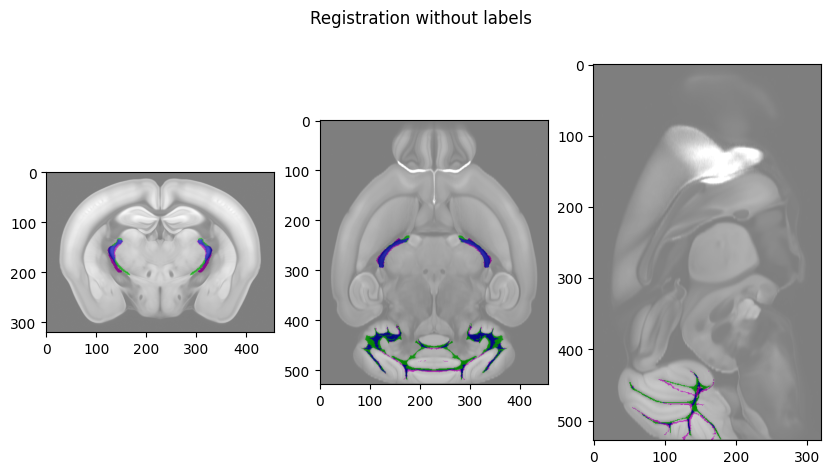

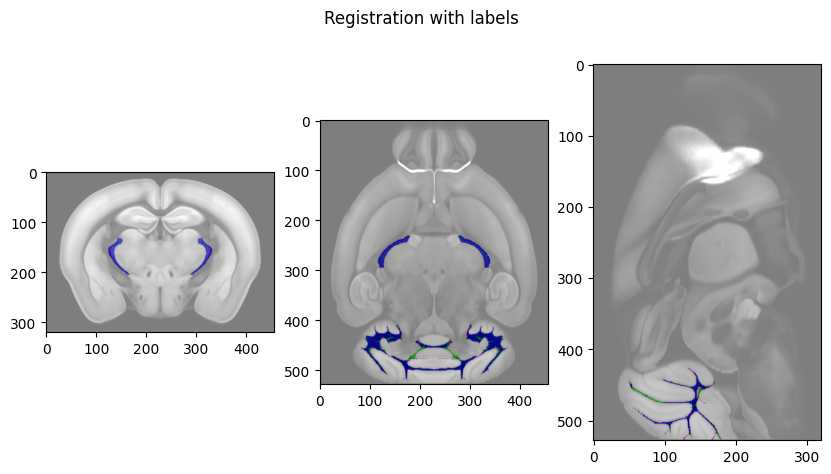

In [23]:


# f1_value1 = f1_score(gt, pred1, labels=valid_labels, average=None, zero_division=np.nan)
# jac_value1 = jaccard_score(gt, pred1, labels=valid_labels, average=None, zero_division=0)

# f1_value2 = f1_score(gt, pred2, labels=valid_labels, average=None, zero_division=np.nan)
# jac_value2 = jaccard_score(gt, pred2, labels=valid_labels, average=None, zero_division=0)   

# print(f"Before reggistration: Dice={f1_value1[0]}, Jaccard={jac_value1[0]}")
# print(f"After reggistration: Dice={f1_value2[0]}, Jaccard={jac_value2[0]}")
    
valid_labels = [1.0]
gt = labels_ccf.numpy().flatten()
pred1 = labels_moved1.numpy().flatten()
pred2 = labels_moved2.numpy().flatten()


title = "Before registration"
compute_metrics(gt, pred1, valid_labels, title)
# compute_metrics(pred1, gt, valid_labels, title)

title = "After registration"
compute_metrics(gt, pred2, valid_labels, title)
# compute_metrics(pred2, gt, valid_labels, title)



Before registration: overlap=0.63
After registration: overlap=0.88
